## Build an MTH5 and Operate the Aurora Pipeline

This notebook pulls MT miniSEED data from the IRIS Dataselect web service and produces MTH5 out of it. It outlines the process of making an MTH5 file, generating a processing config, and running the Aurora processor.

It assumes that aurora, mth5, and mt_metadata have all been installed.

In [49]:
# Required imports for theh program. 
from pathlib import Path
import pandas as pd
from mth5.clients.make_mth5 import MakeMTH5
from mth5 import mth5, timeseries
from mt_metadata.utils.mttime import get_now_utc, MTime
from aurora.config import BANDS_DEFAULT_FILE
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5_new import process_mth5
from aurora.tf_kernel.dataset import DatasetDefinition
from aurora.tf_kernel.helpers import extract_run_summary_from_mth5



Build an MTH5 file from information extracted by IRIS

In [52]:
# Set path so MTH5 file builds to current working directory. 
default_path = Path().cwd()
default_path

PosixPath('/home/kkappler/software/irismt/aurora/docs/notebooks')

In [3]:
# Initialize the Make MTH5 code. 
m = MakeMTH5(mth5_version='0.1.0')
m.client = "IRIS"

In [4]:
# Generate data frame of FDSN Network, Station, Location, Channel, Startime, Endtime codes of interest

CAS04LQE = ['8P', 'CAS04', '', 'LQE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04LQN = ['8P', 'CAS04', '', 'LQN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04BFE = ['8P', 'CAS04', '', 'LFE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04BFN = ['8P', 'CAS04', '', 'LFN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04BFZ = ['8P', 'CAS04', '', 'LFZ', '2020-06-02T19:00:00', '2020-07-13T19:00:00']

request_list = [CAS04LQE, CAS04LQN, CAS04BFE, CAS04BFN, CAS04BFZ]

# Turn list into dataframe
request_df =  pd.DataFrame(request_list, columns=m.column_names)

In [5]:
# Inspect the dataframe
print(request_df)

  network station location channel                start                  end
0      8P   CAS04              LQE  2020-06-02T19:00:00  2020-07-13T19:00:00
1      8P   CAS04              LQN  2020-06-02T19:00:00  2020-07-13T19:00:00
2      8P   CAS04              LFE  2020-06-02T19:00:00  2020-07-13T19:00:00
3      8P   CAS04              LFN  2020-06-02T19:00:00  2020-07-13T19:00:00
4      8P   CAS04              LFZ  2020-06-02T19:00:00  2020-07-13T19:00:00


In [6]:
# Request the inventory information from IRIS
inventory = m.get_inventory_from_df(request_df, data=False)

In [7]:
# Inspect the inventory
inventory

(Inventory created at 2022-05-28T21:10:56.007167Z
	Created by: ObsPy 1.2.2
		    https://www.obspy.org
	Sending institution: MTH5
	Contains:
		Networks (1):
			8P
		Stations (1):
			8P.CAS04 (Corral Hollow, CA, USA)
		Channels (5):
			8P.CAS04..LFZ, 8P.CAS04..LFN, 8P.CAS04..LFE, 8P.CAS04..LQN, 
			8P.CAS04..LQE,
 0 Trace(s) in Stream:
)

Builds an MTH5 file from the user defined database. 
Note: Intact keeps the MTH5 open after it is done building


With the mth5 object set, we are ready to actually request the data from the fdsn client (IRIS) and save it to an MTH5 file.  This process builds an MTH5 file and can take some time depending on how much data is requested.  

Note: interact keeps the MTH5 open after it is done building


In [8]:
interact = True
mth5_object = m.make_mth5_from_fdsnclient(request_df, interact=interact)

2022-05-28 14:11:03,379 [line 591] mth5.mth5.MTH5.open_mth5 - WARNING: 8P_CAS04.h5 will be overwritten in 'w' mode
2022-05-28 14:11:03,787 [line 656] mth5.mth5.MTH5._initialize_file - INFO: Initialized MTH5 0.1.0 file /home/kkappler/software/irismt/aurora/docs/notebooks/8P_CAS04.h5 in mode w
2022-05-28 14:12:04,353 [line 121] mt_metadata.base.metadata.station.add_run - WARNING: Run a is being overwritten with current information


2022-05-28T14:12:04 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-05-28T14:12:04 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter
2022-05-28T14:12:04 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-05-28T14:12:04 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter
More or less runs have been requested by the user than are defined in the metadata. Runs will be defined but only the requested run extents contain time series data based on the users request.


2022-05-28 14:12:06,931 [line 224] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: start time of dataset 2020-06-02T19:00:00+00:00 does not match metadata start 2020-06-02T18:41:43+00:00 updating metatdata value to 2020-06-02T19:00:00+00:00
2022-05-28 14:12:28,821 [line 462] mth5.timeseries.run_ts.RunTS.from_obspy_stream - WARNING: could not find ey
2022-05-28 14:12:42,180 [line 462] mth5.timeseries.run_ts.RunTS.from_obspy_stream - WARNING: could not find ex
2022-05-28 14:12:42,284 [line 462] mth5.timeseries.run_ts.RunTS.from_obspy_stream - WARNING: could not find ey
2022-05-28 14:12:42,774 [line 235] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2020-07-13T19:00:00+00:00 does not match metadata end 2020-07-13T21:46:12+00:00 updating metatdata value to 2020-07-13T19:00:00+00:00


### Examine and Update the MTH5 object

With the open MTH5 Object, we can start to examine what is in it. For example, we retrieve the filename and file_version. You can additionally do things such as getting the station information and edit it by setting a new value, in this case the declination model. 

In [10]:
mth5_object

/:
    |- Group: Survey
    ----------------
        |- Group: Filters
        -----------------
            |- Group: coefficient
            ---------------------
                |- Group: electric_analog_to_digital
                ------------------------------------
                |- Group: electric_dipole_92.000
                --------------------------------
                |- Group: electric_si_units
                ---------------------------
                |- Group: magnetic_analog_to_digital
                ------------------------------------
            |- Group: fap
            -------------
            |- Group: fir
            -------------
            |- Group: time_delay
            --------------------
                |- Group: electric_time_offset
                ------------------------------
                |- Group: hx_time_offset
                ------------------------
                |- Group: hy_time_offset
                ------------------------
         

## If MTH5 file already exists you can start here
If you dont want to execute the previous code to get data again

In [60]:
#interact = False
if interact:
    pass
else:
    h5_path = default_path.joinpath("8P_CAS04.h5")
    mth5_object = mth5.MTH5(file_version="0.1.0")
    mth5_object.open_mth5(config.stations.local.mth5_path, mode="a")



In [55]:
# Collect information from the MTh5 Object and use it in the config files. 
mth5_filename = mth5_object.filename
version = mth5_object.file_version
print(mth5_filename)

/home/kkappler/software/irismt/aurora/docs/notebooks/8P_CAS04.h5


In [12]:
# Edit and update the MTH5 metadata 
s = mth5_object.get_station("CAS04")
print(s.metadata.location.declination.model)
s.metadata.location.declination.model = 'IGRF'
print(s.metadata.location.declination.model)
s.write_metadata()    # writes to file mth5_filename

IGRF-13
IGRF


Now we look more closely at the metadata. Start by calling .summarize() to initialize the channel_summary if we have not yet closed the mth5 object (we have not).  Then by calling .to_dataframe() we can start calling on attributes such as run or sample_rate. 

In [56]:
# Get the available stations and runs from the MTH5 object
mth5_object.channel_summary.summarize()
ch_summary = mth5_object.channel_summary.to_dataframe()

In [57]:
ch_summary

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,ex,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,ey,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hx,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hy,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hz,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


In [58]:
available_runs = ch_summary.run.unique()
sr = ch_summary.sample_rate.unique()
if len(sr) != 1:
    print('Only one sample rate per run is available')
available_stations = ch_summary.station.unique()

In [14]:
ch_summary

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,ex,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,ey,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hx,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hy,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hz,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


In [17]:
available_runs = ch_summary.run.unique()
sr = ch_summary.sample_rate.unique()
if len(sr) != 1:
    print('Only one sample rate per run is available')
available_stations = ch_summary.station.unique()

In [62]:
available_runs


array(['a', 'b', 'c', 'd'], dtype=object)

In [63]:
mth5_object.filename


PosixPath('/home/kkappler/software/irismt/aurora/docs/notebooks/8P_CAS04.h5')

In [18]:
available_stations[0]

'CAS04'

In [19]:
mth5_object

/:
    |- Group: Survey
    ----------------
        |- Group: Filters
        -----------------
            |- Group: coefficient
            ---------------------
                |- Group: electric_analog_to_digital
                ------------------------------------
                |- Group: electric_dipole_92.000
                --------------------------------
                |- Group: electric_si_units
                ---------------------------
                |- Group: magnetic_analog_to_digital
                ------------------------------------
            |- Group: fap
            -------------
            |- Group: fir
            -------------
            |- Group: time_delay
            --------------------
                |- Group: electric_time_offset
                ------------------------------
                |- Group: hx_time_offset
                ------------------------
                |- Group: hy_time_offset
                ------------------------
         

### Generate an Aurora Configuration file using MTH5 as an input

Up to this point, we have used mth5 and mt_metadata, but haven't yet used aurora. So we will use the MTH5 that we just created (and examined and updated) as input into Aurora.

First, we get a list of the available runs to process from the MTH5 

In [2]:
mth5_path = Path("/home/kkappler/software/irismt/aurora/docs/notebooks/8P_CAS04.h5")
from aurora.tf_kernel.helpers import extract_run_summaries_from_mth5s
run_summary = extract_run_summaries_from_mth5s([mth5_path,])

2022-05-28 15:01:49,255 [line 731] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/docs/notebooks/8P_CAS04.h5


0 CAS04 a
        survey station run   latitude   longitude  elevation component  \
0  CONUS South   CAS04   a  37.633351 -121.468382   329.3875        ex   
1  CONUS South   CAS04   a  37.633351 -121.468382   329.3875        ey   
2  CONUS South   CAS04   a  37.633351 -121.468382   329.3875        hx   
3  CONUS South   CAS04   a  37.633351 -121.468382   329.3875        hy   
4  CONUS South   CAS04   a  37.633351 -121.468382   329.3875        hz   

                      start                       end  n_samples  sample_rate  \
0 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00      11267          1.0   
1 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00      11267          1.0   
2 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00      11267          1.0   
3 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00      11267          1.0   
4 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00      11267          1.0   

  measurement_type  azimuth  tilt           units         

## Otherwise, work from the mth5_object

In [32]:
run_summary = extract_run_summary_from_mth5(mth5_object)


0 CAS04 a
        survey station run   latitude   longitude  elevation component  \
0  CONUS South   CAS04   a  37.633351 -121.468382   329.3875        ex   
1  CONUS South   CAS04   a  37.633351 -121.468382   329.3875        ey   
2  CONUS South   CAS04   a  37.633351 -121.468382   329.3875        hx   
3  CONUS South   CAS04   a  37.633351 -121.468382   329.3875        hy   
4  CONUS South   CAS04   a  37.633351 -121.468382   329.3875        hz   

                      start                       end  n_samples  sample_rate  \
0 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00      11267          1.0   
1 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00      11267          1.0   
2 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00      11267          1.0   
3 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00      11267          1.0   
4 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00      11267          1.0   

  measurement_type  azimuth  tilt           units         

In [34]:
print(run_summary.columns)

Index(['station_id', 'run_id', 'start', 'end', 'sample_rate', 'input_channels',
       'output_channels', 'channel_scale_factors', 'mth5_path', 'remote',
       'mth5_obj', 'run', 'run_dataarray', 'stft'],
      dtype='object')


In [35]:
print(run_summary[['station_id', 'run_id', 'start', 'end', ]])

  station_id run_id                     start                       end
0      CAS04      a 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00
1      CAS04      b 2020-06-02 22:24:55+00:00 2020-06-12 17:52:23+00:00
2      CAS04      c 2020-06-12 18:32:17+00:00 2020-07-01 17:32:59+00:00
3      CAS04      d 2020-07-01 19:36:55+00:00 2020-07-13 19:00:00+00:00


There are no reference stations, set all rows to False

In [36]:
run_summary["remote"] = False

Make an aurora configuration file (and then save that json file.)

In [40]:
    cc = ConfigCreator()#config_path=CONFIG_PATH)
    config = cc.create_run_processing_object(emtf_band_file=BANDS_DEFAULT_FILE,
                                        sample_rate=sr[0]
                                        )
    config.stations.from_dataset_dataframe(run_summary)
    for decimation in config.decimations:
        decimation.estimator.engine = "RME"

Take a look at the config:

In [41]:
config

{
    "processing": {
        "decimations": [
            {
                "decimation_level": {
                    "anti_alias_filter": "default",
                    "bands": [
                        {
                            "band": {
                                "decimation_level": 0,
                                "frequency_max": 0,
                                "frequency_min": 0,
                                "index_max": 30,
                                "index_min": 25
                            }
                        },
                        {
                            "band": {
                                "decimation_level": 0,
                                "frequency_max": 0,
                                "frequency_min": 0,
                                "index_max": 24,
                                "index_min": 20
                            }
                        },
                        {
                            "band": {


Run the Aurora Pipeline using the input MTh5 and Confiugration File

In [46]:
dataset_definition = DatasetDefinition()
dataset_definition.df = run_summary
dataset_definition.df

2022-05-28 15:30:53,113 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:30:53,114 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:30:53,115 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:30:53,116 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:30:54,191 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:30:54,192 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:30:54,193 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:30:54,194 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.


,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,mth5_path,remote,mth5_obj,run,run_dataarray,stft
0,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/not...,False,HDF5 file is closed and cannot be accessed.,MTH5 file is closed and cannot be accessed.,[[<xarray.DataArray ()>\narray(139890.31431532...,None
1,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/not...,False,HDF5 file is closed and cannot be accessed.,MTH5 file is closed and cannot be accessed.,[[<xarray.DataArray ()>\narray(-7814.971096474...,None
2,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/not...,False,HDF5 file is closed and cannot be accessed.,MTH5 file is closed and cannot be accessed.,[[<xarray.DataArray ()>\narray(752.93445008557...,None
3,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/not...,False,HDF5 file is closed and cannot be accessed.,MTH5 file is closed and cannot be accessed.,[[<xarray.DataArray ()>\narray(-48846.68186484...,None


Select the runs you want to process

In [47]:
run_list = ['b',]
new_df = dataset_definition.restrict_runs_by_station("CAS04", run_list, overwrite=True)
print(new_df)
dataset_definition.df

2022-05-28 15:30:55,411 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:30:55,686 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.


   index station_id run_id                     start  \
0      1      CAS04      b 2020-06-02 22:24:55+00:00   

                        end  sample_rate input_channels output_channels  \
0 2020-06-12 17:52:23+00:00          1.0       [hx, hy]    [ex, ey, hz]   

                               channel_scale_factors  \
0  {'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...   

                                           mth5_path  remote  \
0  /home/kkappler/software/irismt/aurora/docs/not...   False   

                                      mth5_obj  \
0  HDF5 file is closed and cannot be accessed.   

                                           run  \
0  MTH5 file is closed and cannot be accessed.   

                                       run_dataarray  stft  
0  [[<xarray.DataArray ()>\narray(-7814.971096474...  None  


2022-05-28 15:30:55,953 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.


,index,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,mth5_path,remote,mth5_obj,run,run_dataarray,stft
0,1,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/not...,False,HDF5 file is closed and cannot be accessed.,MTH5 file is closed and cannot be accessed.,[[<xarray.DataArray ()>\narray(-7814.971096474...,None


Processing config indicates 4 decimation levels 
The decimation_level_config here does not have the scale factors, which are needed in make_stft_objects
fix this so that it gets from config based on station_id, without caring if local or remote


/home/kkappler/software/irismt/aurora/aurora/pipelines/time_series_helpers_new.py:228: RuntimeWarning: invalid value encountered in true_divide
  stft_obj[channel_id].data /= calibration_response


merge-o-rama
Processing band 25.728968s
Processing band 19.929573s
Processing band 15.164131s
Processing band 11.746086s
Processing band 9.195791s
Processing band 7.362526s
Processing band 5.856115s
Processing band 4.682492s
GET PLOTTER FROM MTpy
OK, now ser linewidth and markersize


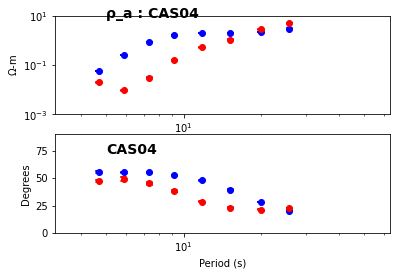

/home/kkappler/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


The decimation_level_config here does not have the scale factors, which are needed in make_stft_objects
fix this so that it gets from config based on station_id, without caring if local or remote


/home/kkappler/software/irismt/aurora/aurora/pipelines/time_series_helpers_new.py:228: RuntimeWarning: invalid value encountered in true_divide
  stft_obj[channel_id].data /= calibration_response


merge-o-rama
Processing band 102.915872s
Processing band 85.631182s
Processing band 68.881694s
Processing band 54.195827s
Processing band 43.003958s
Processing band 33.310722s
GET PLOTTER FROM MTpy
OK, now ser linewidth and markersize


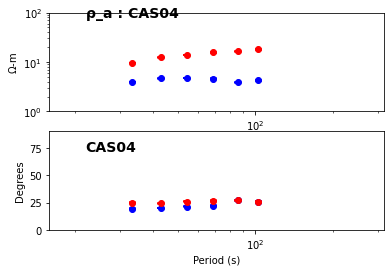

/home/kkappler/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


The decimation_level_config here does not have the scale factors, which are needed in make_stft_objects
fix this so that it gets from config based on station_id, without caring if local or remote


/home/kkappler/software/irismt/aurora/aurora/pipelines/time_series_helpers_new.py:228: RuntimeWarning: invalid value encountered in true_divide
  stft_obj[channel_id].data /= calibration_response


merge-o-rama
Processing band 411.663489s
Processing band 342.524727s
Processing band 275.526776s
Processing band 216.783308s
Processing band 172.015831s
Processing band 133.242890s
GET PLOTTER FROM MTpy
OK, now ser linewidth and markersize


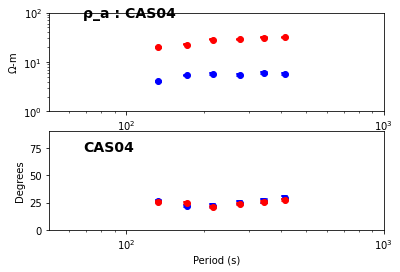

/home/kkappler/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


The decimation_level_config here does not have the scale factors, which are needed in make_stft_objects
fix this so that it gets from config based on station_id, without caring if local or remote


/home/kkappler/software/irismt/aurora/aurora/pipelines/time_series_helpers_new.py:228: RuntimeWarning: invalid value encountered in true_divide
  stft_obj[channel_id].data /= calibration_response


merge-o-rama
Processing band 1514.701336s
Processing band 1042.488956s
Processing band 723.371271s
Processing band 532.971560s
Processing band 412.837995s
GET PLOTTER FROM MTpy
OK, now ser linewidth and markersize


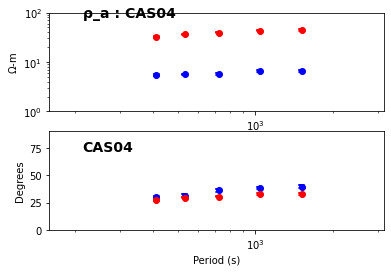

Need to review this info @Jared, review role of local_run_obj in export tf 


2022-05-28 15:31:22,881 [line 731] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/docs/notebooks/8P_CAS04.h5


['b']


In [48]:
show_plot = True
tf_cls = process_mth5(config,
                    dataset_definition,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                    return_collection=False
                )

In [23]:
dataset_definition.df

2022-05-28 15:16:45,951 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:16:45,953 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:16:45,955 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:16:45,956 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:16:46,990 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:16:46,991 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:16:46,991 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.
2022-05-28 15:16:46,992 [line 113] mth5.groups.base.Run.__str__ - WARNING: MTH5 file is closed and cannot be accessed.


,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,mth5_path,remote,mth5_obj,run,run_dataarray,stft
0,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/not...,False,HDF5 file is closed and cannot be accessed.,MTH5 file is closed and cannot be accessed.,[[<xarray.DataArray ()>\narray(139890.31431532...,None
1,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/not...,False,HDF5 file is closed and cannot be accessed.,MTH5 file is closed and cannot be accessed.,[[<xarray.DataArray ()>\narray(-7814.971096474...,None
2,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/not...,False,HDF5 file is closed and cannot be accessed.,MTH5 file is closed and cannot be accessed.,[[<xarray.DataArray ()>\narray(752.93445008557...,None
3,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/not...,False,HDF5 file is closed and cannot be accessed.,MTH5 file is closed and cannot be accessed.,[[<xarray.DataArray ()>\narray(-48846.68186484...,None


In [18]:

type(tf_cls)

mt_metadata.transfer_functions.core.TF

Write the transfer functions generated by the Aurora pipeline

In [19]:
 tf_cls.write_tf_file(fn="emtfxml_test.xml", file_type="emtfxml")

2022-05-28 15:12:07,778 [line 197] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote emtfxml_test.xml


EMTFXML(station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39)

In [20]:
tf_cls.write_tf_file(fn="emtfxml_test.xml", file_type="edi")

2022-05-28 15:12:13,782 [line 197] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote emtfxml_test.xml


EMTFXML(station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39)

In [21]:
 tf_cls.write_tf_file(fn="emtfxml_test.xml", file_type="zmm")

2022-05-28 15:12:15,536 [line 197] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote emtfxml_test.xml


EMTFXML(station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39)